#1. Import các thư viện cần thiết


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import glob
from PIL import Image
import shutil
from tqdm import tqdm # Import tqdm
from sklearn.model_selection import train_test_split
from tempfile import TemporaryDirectory
from PIL import Image, UnidentifiedImageError

cudnn.benchmark = True
plt.ion()

#2. Tiền xử lý dữ liệu

In [ ]:
github_list = '''https://github.com/GwLewis369/Hand-written-digit-classification-data.git
https://github.com/gbaonr/CS114_handwritten_digits_data
https://github.com/adamwhite625/CS114_hand_written_digit.git
https://github.com/theRaven1312/CS114.P21
https://github.com/Khoiisme1905/CS114.git
https://github.com/ProjectHT1/machinelearning
https://github.com/Searching96/hand-written-digit.git
https://github.com/Salmon1605/CS114
https://github.com/anhtuann1224/hand_written_digit
https://github.com/NATuanAN/Hand_written_digit_classification_data.git
https://github.com/huapogba/may-hoc
https://github.com/hieutran890j2/CS114.git
https://github.com/votanhoang483/CS114.P21-Hand_written_digit_classification
https://github.com/DHPh/CS114_hand_written_digit/
https://github.com/thaituanUIT/ReminiScenceAI
https://github.com/anngyn/CS114-Hand-Written-Digit
https://github.com/Toan02Ky-UIT/CS114
https://github.com/Lochke/CS114_Handwritten_Digit_Classification.git
https://github.com/toanlamdata/digit-recognition-group
https://github.com/Nohenshin/CS114.P21-2025-
https://github.com/hmcslearning/ML1142025
https://github.com/lngphgthao/cs114-hand-written-digit-classification
https://github.com/huapogba/may-hoc
https://github.com/23520276/Hand-written-digit-classification/
https://github.com/NThong325/CS114
'''

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
data_dir = '/gdrive/MyDrive/DoAN/Bai05/DataGithub'

In [ ]:
%cd $data_dir
!git config --global core.compression 0
!rm -rf $data_dir/*
for i in github_list.split():
  # !echo $i
  # !git clone $i
  dir_name = !echo "$i" | sed -E 's|https://github.com/([^/]+)/([^/]+)(\.git)?|\1_\2|'
  dir_name = dir_name[0]
  # print(dir_name[0])
  !git clone $i /tmp/$dir_name || rm -rf /tmp/$dir_name
  !mv /tmp/$dir_name $data_dir/$dir_name
  # !echo $dir_name
  # !git clone $i

/gdrive/MyDrive/DoAN/Bai05/DataGithub
Cloning into '/tmp/GwLewis369_Hand-written-digit-classification-data.git'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (382/382), done.
remote: Total 397 (delta 5), reused 103 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (397/397), 23.05 MiB | 21.48 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Cloning into '/tmp/gbaonr_CS114_handwritten_digits_data'...
remote: Enumerating objects: 837, done.
remote: Counting objects: 100% (837/837), done.
remote: Compressing objects: 100% (822/822), done.
remote: Total 837 (delta 14), reused 721 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (837/837), 27.23 MiB | 34.60 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Cloning into '/tmp/adamwhite625_CS114_hand_written_digit.git'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (342

In [6]:
a = glob.glob(f'{data_dir}/*/hand_written_digit/??52????')
print(a)
image_lists = []
for folder in a:
  for num in range(10):
    t = glob.glob(f'{folder}/{num}_*')
    image_lists += t

['/gdrive/MyDrive/DoAN/Bai05/DataGithub/GwLewis369_Hand-written-digit-classification-data.git/hand_written_digit/22520369', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/GwLewis369_Hand-written-digit-classification-data.git/hand_written_digit/23521419', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/GwLewis369_Hand-written-digit-classification-data.git/hand_written_digit/23521387', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/gbaonr_CS114_handwritten_digits_data/hand_written_digit/22520069', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/gbaonr_CS114_handwritten_digits_data/hand_written_digit/22520109', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/gbaonr_CS114_handwritten_digits_data/hand_written_digit/22520068', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/adamwhite625_CS114_hand_written_digit.git/hand_written_digit/23520550', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/adamwhite625_CS114_hand_written_digit.git/hand_written_digit/23520667', '/gdrive/MyDrive/DoAN/Bai05/DataGithub/adamwhite625_CS114_hand_written_digit.git/hand_writ

In [ ]:
# Tạo thư mục train và val
base_dataset_path = '/gdrive/MyDrive/DoAN/Bai05/Dataset'
train_path = os.path.join(base_dataset_path, 'train')
val_path = os.path.join(base_dataset_path, 'val')

for p in [train_path, val_path]:
    for i in range(10):
        os.makedirs(os.path.join(p, str(i)), exist_ok=True)

# Chia tập train/val
train_imgs, val_imgs = train_test_split(image_lists, test_size=0.2, random_state=42)

# Hàm copy ảnh vào thư mục theo label
def move_images(image_paths, target_dir):
    for img_path in image_paths:
        label = os.path.basename(img_path).split('_')[0]
        dest = os.path.join(target_dir, label, os.path.basename(img_path))
        try:
            shutil.copy(img_path, dest)
        except Exception as e:
            print(f"Lỗi: {img_path} => {e}")

# Thực hiện di chuyển ảnh
move_images(train_imgs, train_path)
move_images(val_imgs, val_path)

print(f"Tổng số ảnh train: {len(train_imgs)}")
print(f"Tổng số ảnh validation: {len(val_imgs)}")


Tổng số ảnh train: 5486
Tổng số ảnh validation: 1372


In [ ]:
def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        img.close()
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Sử dụng is_valid_file khi tạo ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(base_dataset_path, x),
                                          data_transforms[x],
                                          is_valid_file=is_valid_image) # Thêm tham số này
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Classes:", class_names)
print(f"Số lượng ảnh train sau khi lọc: {dataset_sizes['train']}")
print(f"Số lượng ảnh val sau khi lọc: {dataset_sizes['val']}")

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Số lượng ảnh train sau khi lọc: 4282
Số lượng ảnh val sau khi lọc: 1225


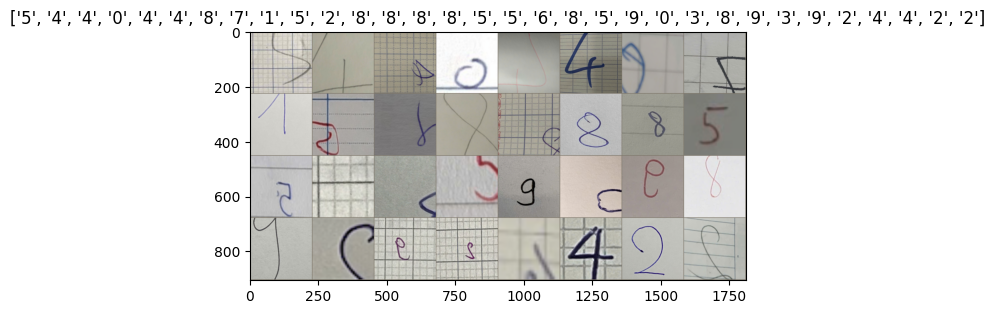

In [ ]:
def imshow(inp, title=None):
    """Hiển thị ảnh tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Hiển thị 1 batch đầu
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


#3. Xây dựng mô hình Resnet18

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Thêm dictionaries để lưu lịch sử
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Thêm tqdm để hiển thị tiến độ
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch+1}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Lưu lịch sử vào dictionary
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())


            # Luu mo hinh co validation cao nhat
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    # Trả về model và lịch sử
    return model, history

#4. Huấn luyện mô hình Resnet18


In [ ]:
model_ft, H = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
--------------------


train Epoch 1: 100%|██████████| 134/134 [18:55<00:00,  8.47s/it]


train Loss: 1.9320 Acc: 0.3167


val Epoch 1: 100%|██████████| 39/39 [02:09<00:00,  3.33s/it]


val Loss: 1.0359 Acc: 0.7233
Epoch 2/10
--------------------


train Epoch 2: 100%|██████████| 134/134 [18:52<00:00,  8.45s/it]


train Loss: 1.1881 Acc: 0.6245


val Epoch 2: 100%|██████████| 39/39 [02:09<00:00,  3.32s/it]


val Loss: 0.6082 Acc: 0.8294
Epoch 3/10
--------------------


train Epoch 3: 100%|██████████| 134/134 [18:55<00:00,  8.47s/it]


train Loss: 0.9506 Acc: 0.6985


val Epoch 3: 100%|██████████| 39/39 [02:09<00:00,  3.32s/it]


val Loss: 0.4621 Acc: 0.8727
Epoch 4/10
--------------------


train Epoch 4: 100%|██████████| 134/134 [18:55<00:00,  8.47s/it]


train Loss: 0.8285 Acc: 0.7387


val Epoch 4: 100%|██████████| 39/39 [02:09<00:00,  3.32s/it]


val Loss: 0.3719 Acc: 0.8922
Epoch 5/10
--------------------


train Epoch 5: 100%|██████████| 134/134 [18:42<00:00,  8.37s/it]


train Loss: 0.7596 Acc: 0.7508


val Epoch 5: 100%|██████████| 39/39 [02:09<00:00,  3.33s/it]


val Loss: 0.3098 Acc: 0.9004
Epoch 6/10
--------------------


train Epoch 6: 100%|██████████| 134/134 [18:47<00:00,  8.42s/it]


train Loss: 0.7137 Acc: 0.7632


val Epoch 6: 100%|██████████| 39/39 [02:12<00:00,  3.40s/it]


val Loss: 0.2848 Acc: 0.9110
Epoch 7/10
--------------------


train Epoch 7: 100%|██████████| 134/134 [18:47<00:00,  8.41s/it]


train Loss: 0.6833 Acc: 0.7716


val Epoch 7: 100%|██████████| 39/39 [02:09<00:00,  3.32s/it]


val Loss: 0.2811 Acc: 0.9143
Epoch 8/10
--------------------


train Epoch 8: 100%|██████████| 134/134 [18:46<00:00,  8.41s/it]


train Loss: 0.6108 Acc: 0.7952


val Epoch 8: 100%|██████████| 39/39 [02:09<00:00,  3.31s/it]


val Loss: 0.2599 Acc: 0.9200
Epoch 9/10
--------------------


train Epoch 9: 100%|██████████| 134/134 [18:48<00:00,  8.42s/it]


train Loss: 0.6158 Acc: 0.8001


val Epoch 9: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]


val Loss: 0.2572 Acc: 0.9184
Epoch 10/10
--------------------


train Epoch 10: 100%|██████████| 134/134 [18:53<00:00,  8.46s/it]


train Loss: 0.5921 Acc: 0.8008


val Epoch 10: 100%|██████████| 39/39 [02:08<00:00,  3.30s/it]

val Loss: 0.2481 Acc: 0.9257

Training complete in 210m 5s
Best val Acc: 0.9257


In [ ]:
torch.save(model_ft.state_dict(), '/gdrive/MyDrive/DoAN/Bai05/model_handwritten_digit.pth')

In [7]:
test_dir = '/gdrive/MyDrive/DoAN/Bai05/data.2025'

#5.Visualization

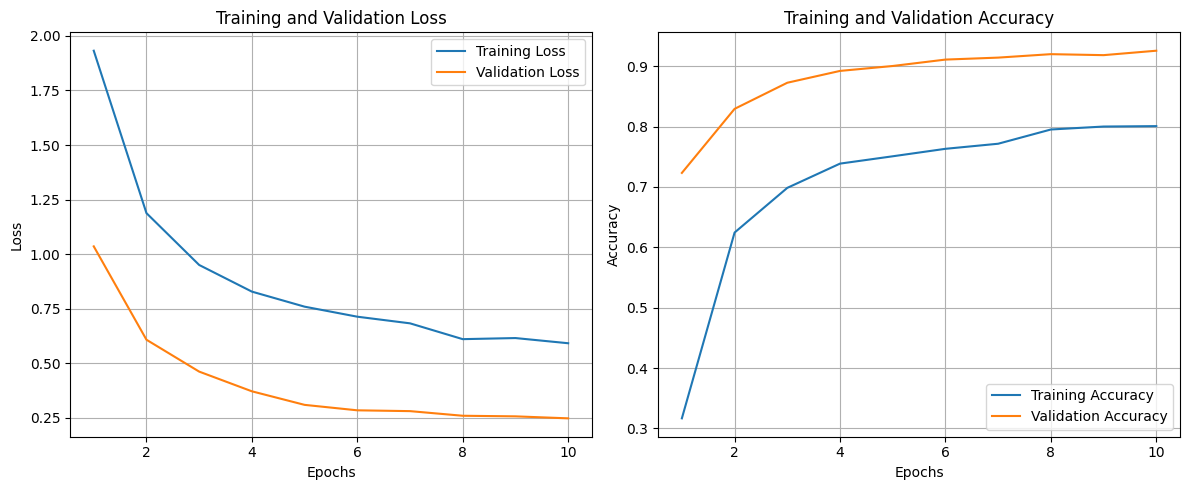

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ đồ thị sau khi training hoàn thành
plot_history(H)


#6. Dự đoán trên dữ liệu

In [8]:
import gdown
import zipfile
import os

# Tải file zip từ Google Drive
url = 'https://drive.google.com/uc?export=download&id=1UhMPzU-84KYH1-ujisJj08kb4Ji7gBLe'
output = '/gdrive/MyDrive/DoAN/Bai05/data.2025.zip'
gdown.download(url, output, quiet=False)

# Giải nén file zip
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/gdrive/MyDrive/DoAN/Bai05/data.2025')

# Đường dẫn đến thư mục chứa ảnh sau khi giải nén
test_dir = '/gdrive/MyDrive/DoAN/Bai05/data.2025'

# Tiếp tục với phần còn lại của code
from torchvision import transforms

# Khai báo tham số ở trên cùng
IMG_SIZE   = (224, 224)
MEAN_STATS = (0.485, 0.456, 0.406)
STD_STATS  = (0.229, 0.224, 0.225)

def build_transform(size, mean, std):
    steps = [
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
    return transforms.Compose(steps)

data_transforms = build_transform(IMG_SIZE, MEAN_STATS, STD_STATS)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1UhMPzU-84KYH1-ujisJj08kb4Ji7gBLe
From (redirected): https://drive.google.com/uc?export=download&id=1UhMPzU-84KYH1-ujisJj08kb4Ji7gBLe&confirm=t&uuid=0168a389-cd47-4f6a-9d32-02c29b5963bd
To: /gdrive/MyDrive/DoAN/Bai05/data.2025.zip
100%|██████████| 2.36G/2.36G [00:41<00:00, 57.4MB/s]


In [ ]:
# load lại mô hình:
import torch # Import torch here
from torchvision import models
import torch.nn as nn

model_path = '/gdrive/MyDrive/DoAN/Bai05/model_handwritten_digit.pth'

# Đảm bảo device đã được khai báo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mopretrained = models.resnet18(False)
num_ftrs = mopretrained.fc.in_features
mopretrained.fc = nn.Linear(num_ftrs, 10)  # 10 lớp cho chữ số 0–9
mopretrained.load_state_dict(torch.load(model_path, map_location=device))
mopretrained = mopretrained.to(device)
mopretrained.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import csv
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm
import pyheif
from torchvision import transforms
import torch
from torchvision import models
import torch.nn as nn

# --- 1. Thiết lập đường dẫn ---
DATA_DIR   = Path('/gdrive/MyDrive/DoAN/Bai05/data.2025')
MODEL_FILE = Path('/gdrive/MyDrive/DoAN/Bai05/model_handwritten_digit.pth')
OUT_CSV    = Path('/gdrive/MyDrive/DoAN/Bai05/predictions.csv')

# --- 2. Thu thập tất cả ảnh với các đuôi mong muốn ---
exts = ['png', 'jpg', 'jpeg', 'jfif', 'heic']
image_paths = []
for e in exts:
    image_paths.extend(DATA_DIR.glob(f'*.{e}'))

# --- 3. Định nghĩa pipeline transform ---
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

# --- 4. Hàm load model đã huấn luyện ---
def load_trained_model(model_path: Path, device: torch.device):
    net = models.resnet18(weights=None)
    # Thay lớp cuối cho 10 class
    net.fc = nn.Linear(net.fc.in_features, 10)
    # Nạp weight
    state = torch.load(model_path, map_location=device)
    net.load_state_dict(state)
    return net.to(device).eval()

# --- 5. Hàm mở ảnh (bao gồm HEIC/HEIF) ---
def open_image(img_path):
    if img_path.suffix.lower() in ['.heic', '.heif']:
        heif_file = pyheif.read(img_path)
        img = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data
        )
    else:
        img = Image.open(img_path).convert('RGB')
    return img

# --- 6. Chạy inference và ghi CSV ---
def run_inference():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_trained_model(MODEL_FILE, device)

    with OUT_CSV.open('w', newline='') as f:
        writer = csv.writer(f)
        for img_path in tqdm(image_paths, desc='Predicting'):
            try:
                img = open_image(img_path)
            except UnidentifiedImageError:
                # nếu file không phải ảnh hợp lệ thì bỏ qua
                continue

            batch = preprocess(img).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(batch)
                pred_label = int(logits.argmax(dim=1))

            writer.writerow([img_path.name, pred_label])

if __name__ == '__main__':
    run_inference()


Predicting:   0%|          | 0/8977 [00:00<?, ?it/s]